# Global Fishing Watch Exploratory Data Analysis

Questions to answer in this script:

Unit of analysis: Ship or ship-year or ship-cruise?
- How long is a cruise for a reefer? 
- Does behaviour change over time?

Fishing vessels:
- Do fishing vessels that have met a bad reefer always meet with bad reefers? --> Can we partition fishing boats in good and bad? 
- How do bad fishing boats differ from good fishing boats? What are characteristics of bad fishers? 
    - flags
    - size
    - time at sea
    - age (year built)
    - owners

For Marc:
- number of loitering within a each rfmo (by countries signed to it and not signed to it) -- Marc to provide list of countries signed to RFMO

Other analysis:
- looking suspicious activity at US ports
- whether reported to designated PSMA port (waiting for Eunyoung's data)


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.2)
color = sns.color_palette("tab10", 10)[0]

In [3]:
wd = "/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/"

Importing data 

In [4]:
def import_data():
    path = '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/xlsx/gfw_data-v2.xlsx'
    xls = pd.ExcelFile(path)
    dfList = []
    for sheet in ['carriers', 'encounter-v2', 'loitering-v2', 'carrier_port_visit-v2']:
        dfList.append(pd.read_excel(path, sheet_name=sheet))
    return dfList

In [5]:
dfList = import_data()

In [6]:
port_visits = dfList[3]
carriers = dfList[0]
encounter = dfList[1]
loitering = dfList[2]

In [7]:
num_encounter = []
num_loitering = []
for i in carriers.id:
    num_encounter.append(encounter[encounter['vessel.id']==i].shape[0])
    num_loitering.append(loitering[loitering['vessel.id']==i].shape[0])

# append the num info into new column in carrier table
carrier = carriers.assign(encounter=num_encounter, loitering = num_loitering)

In [8]:
psma_entry = pd.read_excel(
    '/Users/sebastiandodt/OneDrive/Uni/Carnegie Mellon University/Modules/2022 Fall/Systems Project/Coding/90739-iuu-systems-project/port_evaluation/data/input/Law_Review/Law Review2.xlsx',
    sheet_name = 'PSMA'
)
psma_entry.drop(['Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1, inplace = True)
psma_entry.columns = ['Country', 'Signature', 'Ratification', 'Status']
psma_entry['rat_year'] = psma_entry['Ratification'].str[:4].fillna(0).astype(int)
psma_entry['rat_year'] = psma_entry['rat_year'].replace(0,np.nan)
psma_entry

,Country,Signature,Ratification,Status,rat_year
0,ALB,NaT,2017-04-07 ACS,False,2017.0
1,AGO,2009-11-22,2022-07-20 ACS,False,2022.0
2,AUS,2010-04-27,2015-07-20 RAT,True,2015.0
3,BHS,NaT,2016-10-07 ACS,False,2016.0
4,BGD,NaT,2019-12-20 ACS,False,2019.0
...,...,...,...,...,...
69,GBR,NaT,2021-01-31 ACS,False,2021.0
70,USA,2009-11-22,2016-02-26 RAT,True,2016.0
71,URY,2009-11-22,2013-02-28 RAT,True,2013.0
72,VUT,NaT,2016-05-06 ACS,False,2016.0


In [7]:
loitering['year'] = loitering['end'].str[:4].astype(int)

loitering = loitering.loc[loitering['year'] < 2022, :]
loit = loitering.merge(psma_entry, left_on='vessel.flag', right_on='Country', how='left')
loit['years_after_psma'] = loit['rat_year'] - loit['year']

In [8]:
# of all times
top_perps = loitering.groupby(['vessel.flag'])['id'].count().reset_index().sort_values('id').tail(10)
top_perps

,vessel.flag,id
30,IDN,4394
34,JPN,4486
3,BHS,5389
38,KOR,6429
75,VUT,7455
70,TWN,8805
39,LBR,11285
10,CHN,17344
53,PAN,47638
58,RUS,68266


In [9]:
# per year
loitering_per_year = loitering.groupby(['vessel.flag', 'year'])['id'].count().reset_index()
loitering_per_year

,vessel.flag,year,id
0,ATG,2012,5
1,ATG,2013,6
2,ATG,2014,3
3,ATG,2016,2
4,ATG,2017,2
...,...,...,...
479,VUT,2019,129
480,VUT,2020,155
481,VUT,2021,64
482,WSM,2018,8


In [10]:
loitering_per_psma = loit.groupby(['years_after_psma'])['id'].count().reset_index()
loitering_per_psma['years_after_psma'] = loitering_per_psma['years_after_psma'].astype(int)
loitering_per_psma

,years_after_psma,id
0,-10,397
1,-9,429
2,-8,985
3,-7,275
4,-6,313
5,-5,11557
6,-4,13158
7,-3,8873
8,-2,10237
9,-1,10291


<AxesSubplot: xlabel='years_after_psma', ylabel='id'>

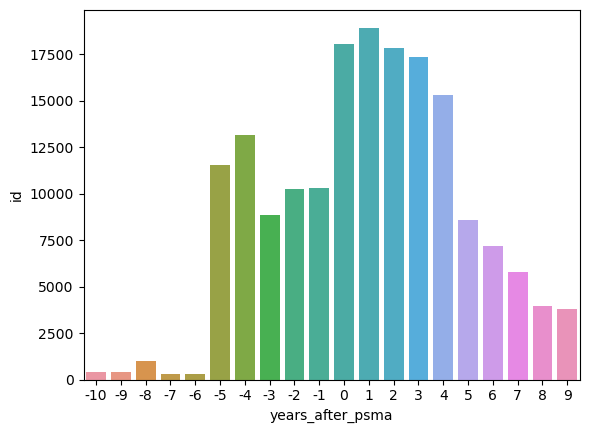

In [11]:
sns.barplot(loitering_per_psma, x ='years_after_psma', y='id')

<AxesSubplot: xlabel='year', ylabel='id'>

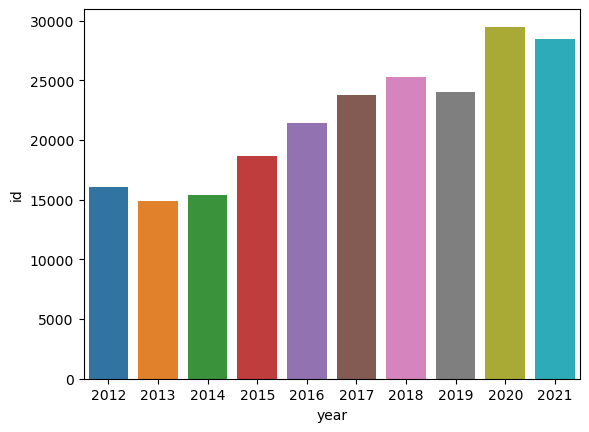

In [12]:
absolute = loitering.groupby('year')['id'].count().reset_index()
sns.barplot(absolute, x ='year', y='id')

In [13]:
loitering_per_psma = loit.groupby(['years_after_psma', 'vessel.flag'])['id'].count().reset_index()
loitering_per_psma['years_after_psma'] = loitering_per_psma['years_after_psma'].astype(int)
loitering_per_psma['id_log'] = np.log10(loitering_per_psma['id'])

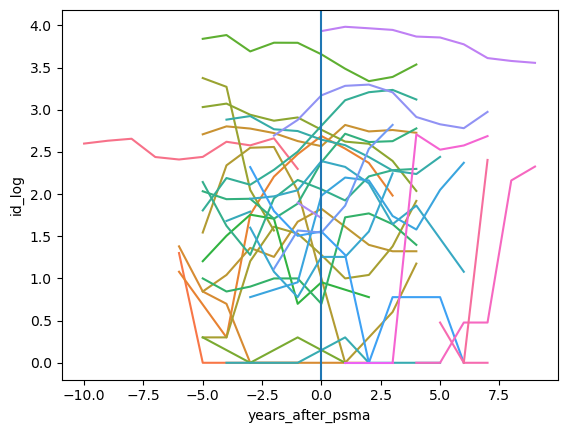

In [14]:
sns.lineplot(loitering_per_psma, x ='years_after_psma', y='id_log', hue='vessel.flag', legend=False)
plt.axvline(0, 0,1)

In [15]:
loitering_per_psma_filtered = loitering_per_psma[loitering_per_psma['vessel.flag'].isin(top_perps['vessel.flag'])]

Text(0, 0.5, 'Number of loitering')

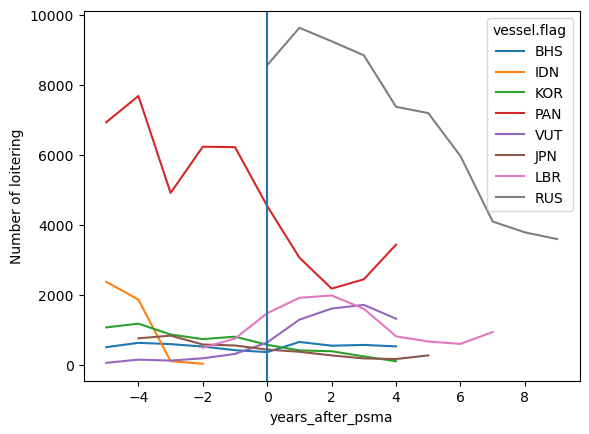

In [16]:
sns.lineplot(loitering_per_psma_filtered, x ='years_after_psma', y='id', hue='vessel.flag')
plt.axvline(0, 0,1)
plt.ylabel('Number of loitering')

## Port visits

In [17]:
port_visits['year'] = port_visits['end'].str[:4].astype(int).copy()
port_visits = port_visits.loc[port_visits['year'] < 2022, :]
port_visits = port_visits.loc[port_visits['vessel.id'].isin(carriers['id']), :]
ports = port_visits.merge(psma_entry, left_on='vessel.flag', right_on='Country', how='left')
ports['years_after_psma'] = ports['rat_year'] - loit['year'] 

In [18]:
top_perps = ports.groupby(['port.country'])['id'].count().reset_index().sort_values('id').tail(10)
top_perps

,port.country,id
19,CAN,7273
42,ESP,7524
83,KOR,13944
117,PAN,15613
21,CHN,17953
79,JPN,22307
130,RUS,31243
112,NOR,36219
20,CHL,36304
159,USA,42393


In [19]:
ports_per_year = port_visits.groupby(['port.country', 'year'])['id'].count().reset_index()
ports_per_year

,port.country,year,id
0,ABW,2012,21
1,ABW,2013,39
2,ABW,2014,61
3,ABW,2015,51
4,ABW,2016,62
...,...,...,...
1436,ZAF,2017,187
1437,ZAF,2018,188
1438,ZAF,2019,148
1439,ZAF,2020,162


In [20]:
ports_psma = ports.groupby(['years_after_psma'])['id'].count().reset_index()
ports_psma['years_after_psma'] = ports_psma['years_after_psma'].astype(int)

<AxesSubplot: xlabel='years_after_psma', ylabel='id'>

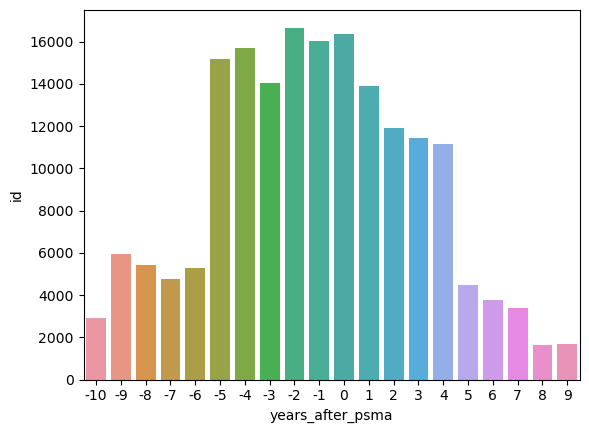

In [21]:
sns.barplot(ports_psma, x ='years_after_psma', y='id')

<AxesSubplot: xlabel='year', ylabel='id'>

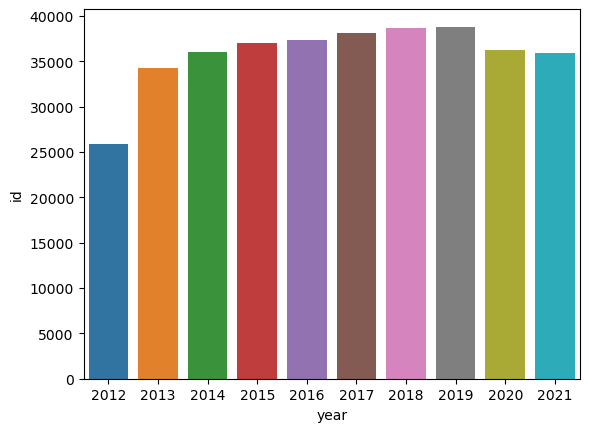

In [22]:
absolute = port_visits.groupby('year')['id'].count().reset_index()
sns.barplot(absolute, x ='year', y='id')

In [23]:
ports_psma2 = ports.groupby(['years_after_psma', 'port.country'])['id'].count().reset_index()
ports_psma2['years_after_psma'] = ports_psma2['years_after_psma'].astype(int)
ports_psma2['id_log'] = np.log10(ports_psma2['id'])

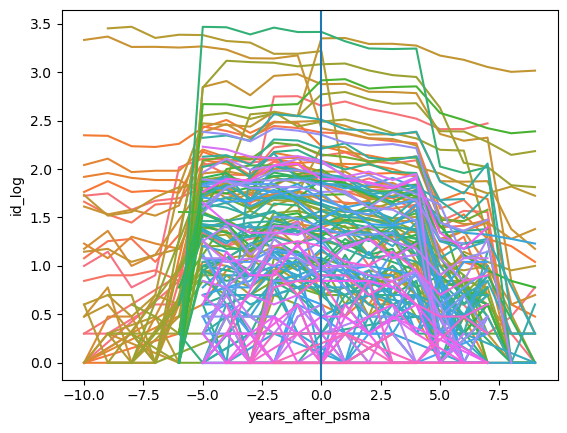

In [24]:
sns.lineplot(ports_psma2, x ='years_after_psma', y='id_log', hue='port.country', legend=False)
plt.axvline(0, 0,1)

In [25]:
ports_psma_filt = ports_psma2[ports_psma2['port.country'].isin(top_perps['port.country'])]

Text(0.5, 0, 'Years from PSMA ratification')

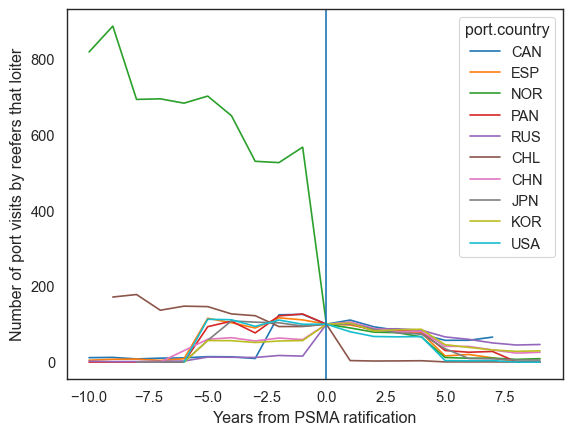

In [37]:
sns.lineplot(ports_psma_filt, x ='years_after_psma', y='id', hue='port.country')
plt.axvline(0, 0,1)
plt.ylabel('Number of port visits by reefers that loiter')
plt.xlabel('Years from PSMA ratification')

In [27]:
ports_psma_filt['visits'] = ports_psma_filt['id'].copy()
ports_psma2['visits'] = ports_psma2['id'].copy()
for country in ports_psma2['port.country'].unique():
    if country in ports_psma_filt['port.country'].unique():
        psma_year = ports_psma_filt.loc[((ports_psma_filt['port.country'] == country)&(ports_psma_filt['years_after_psma'] == 0)),'id']
        ports_psma_filt.loc[ports_psma_filt['port.country'] == country,'id'] /= float(psma_year)/100
    psma_year = ports_psma2.loc[((ports_psma2['port.country'] == country)&(ports_psma2['years_after_psma'] == 0)),'id']
    if len(psma_year) >0:
        ports_psma2.loc[ports_psma2['port.country'] == country,'id'] /= float(psma_year)/100

/var/folders/8z/3jxkd1111yv6m0gf9g9kqmdr0000gn/T/ipykernel_35085/1286327196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ports_psma_filt['visits'] = ports_psma_filt['id'].copy()


In [28]:
ports_psma2.loc[((ports_psma2['port.country'] == 'FIN')&(ports_psma2['years_after_psma'] == -1)),'id']

775    1.0
Name: id, dtype: float64

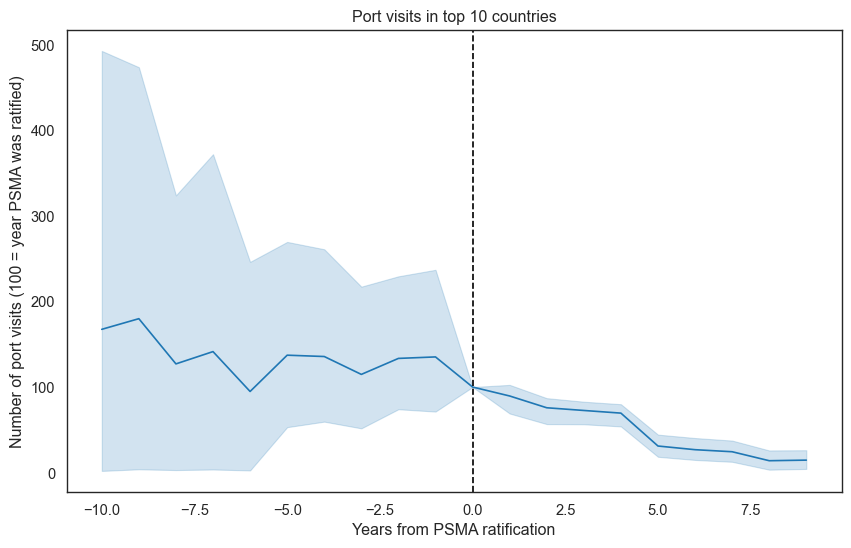

In [41]:
sns.set_style('white')
sns.set_context("paper", font_scale = 1.2)
color = sns.color_palette("tab10", 10)[0]
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ports_psma_filt, x ='years_after_psma', y='id', ax=ax)
plt.axvline(0, 0,1, color='black', linestyle='--')
plt.ylabel('Number of port visits (100 = year PSMA was ratified)')
plt.xlabel('Years from PSMA ratification')
plt.title('Port visits in top 10 countries')
# ax.set_title('Share of meetings with dark vessels for each 10% of reefers',fontdict= { 'fontsize': 14, 'fontweight':'bold'})
plt.savefig(wd + 'port_evaluation/output/psma.png', dpi=500)
plt.show()

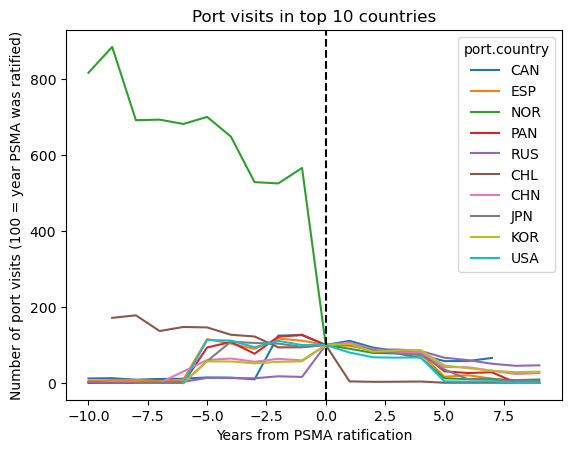

In [33]:
sns.lineplot(ports_psma_filt, x ='years_after_psma', y='id', hue='port.country')
plt.axvline(0, 0,1, color='black', linestyle='--')
plt.ylabel('Number of port visits (100 = year PSMA was ratified)')
plt.xlabel('Years from PSMA ratification')
plt.title('Port visits in top 10 countries')
plt.show()

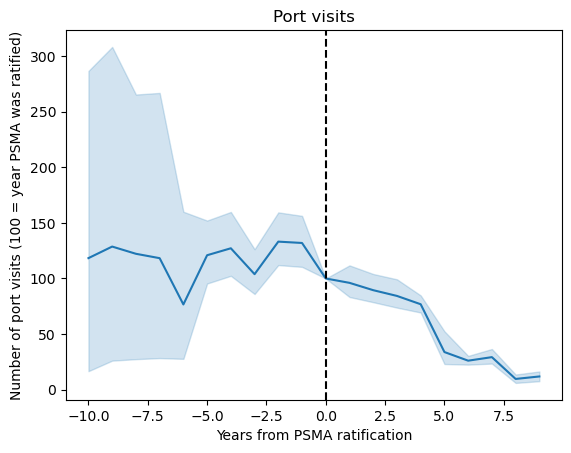

In [30]:
sns.lineplot(ports_psma2, x ='years_after_psma', y='id')
plt.axvline(0, 0,1, color='black', linestyle='--')
plt.ylabel('Number of port visits (100 = year PSMA was ratified)')
plt.xlabel('Years from PSMA ratification')
plt.title('Port visits')
plt.show()

In [31]:
ports_psma_filt
## possible additions: 
## relative in percent to ratification year
## relative to total loiterings and port visits in the respective year

,years_after_psma,port.country,id,id_log,visits
3,-10,CAN,11.804009,1.724276,53
8,-10,ESP,5.042017,1.079181,12
22,-10,NOR,817.490494,3.332438,2150
23,-10,PAN,0.133156,0.000000,1
25,-10,RUS,2.419355,1.732394,54
...,...,...,...,...,...
1932,9,KOR,29.769137,2.389166,245
1937,9,NOR,9.125475,1.380211,24
1939,9,PAN,0.266312,0.301030,2
1940,9,RUS,46.460573,3.015779,1037


In [32]:
ports

,id,type,start,end,lat,lon,vessel.id,vessel.type,vessel.mmsi,vessel.name,...,port.lon,port.country,port.name,year,Country,Signature,Ratification,Status,rat_year,years_after_psma
0,af03d0b85979b8c91ae5ea165d0fd2e0,port,2012-10-24 12:21:05 UTC,2012-10-24 21:07:44 UTC,18.460661,-66.111945,3fe8729f8-80c4-2d9b-70cb-02aa09353f4e,carrier,311295000,DOLE ASIA,...,-66.111945,PRI,SAN JUAN,2012,BHS,NaT,2016-10-07 ACS,False,2016.0,3.0
1,76c123fc888c38f8424d444308e74739,port,2012-10-24 10:00:48 UTC,2012-10-26 14:49:48 UTC,8.024300,-76.780133,b3089e7df-fd55-d6e8-2292-e7bb093023fe,carrier,308090000,HELLAS STREAM,...,-76.780133,COL,TURBO,2012,BHS,NaT,2016-10-07 ACS,False,2016.0,3.0
2,a3910ba2f8e734f7343fe2c3886e031a,port,2012-10-24 23:02:21 UTC,2012-10-25 16:23:59 UTC,62.777300,6.917326,1c3ee5f35-5189-56ac-07a5-a99a6624b7aa,carrier,311411000,SAMSKIP ICE,...,6.917326,NOR,NaN,2012,BHS,NaT,2016-10-07 ACS,False,2016.0,3.0
3,c3bf496236204dead751072c35d5fefc,port,2012-10-24 14:57:38 UTC,2012-10-25 16:49:53 UTC,-16.990203,-72.142333,65032eb47-732f-946e-ea32-03567b0cefd8,carrier,636011106,BALTIC PRIDE,...,-72.142333,PER,MATARANI,2012,LBR,NaT,2019-05-21 ACS,False,2019.0,6.0
4,a83c2693989f78c894add34cab5b4168,port,2012-10-24 13:41:32 UTC,2012-11-02 00:54:58 UTC,9.396368,-79.923693,18396295f-f8dc-e456-fdc6-cd15ac97d99d,carrier,311062400,DITLEV REEFER,...,-79.923693,PAN,COLON,2012,BHS,NaT,2016-10-07 ACS,False,2016.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358417,aff87f2eaf4a3b9970b3e1a260785093,port,2014-01-04 22:05:39 UTC,2014-01-05 06:56:39 UTC,22.070625,114.078650,a942d10ac-ca2e-4f3d-97b9-8afef0a7e3a3,carrier,352308000,CRYSTAL WAY,...,114.078650,CHN,HONG KONG,2014,PAN,NaT,2016-11-21 ACS,False,2016.0,NaN
358418,0e7b14c243a93041c4c06adabd3e8980,port,2014-01-04 09:49:16 UTC,2014-01-08 10:50:51 UTC,20.755195,-17.061572,b0987bd59-9c06-757f-fdf5-85ed4dc1ccb5,carrier,312174000,RANGIROA,...,-17.061572,MRT,NOUADHIBOU,2014,NaN,NaT,NaN,NaN,NaN,NaN
358419,eccf74a3775010a62c7ef191e782a7c9,port,2014-01-04 00:53:46 UTC,2014-01-05 05:03:33 UTC,51.298117,4.315254,f3bef3860-009c-e707-8995-895e9942e745,carrier,566060000,STAR ENDEAVOUR I,...,4.315254,BEL,ANTWERP,2014,NaN,NaT,NaN,NaN,NaN,NaN
358420,fcec23ab8f3892b6d258d6c5ca4ca558,port,2014-01-04 13:26:44 UTC,2014-01-14 03:38:46 UTC,45.287153,14.406227,dd8ce3711-1009-7679-24b1-4582c408ec4c,carrier,314233000,BOSSE,...,14.406227,HRV,RIJEKA LUKA,2014,BRB,NaT,2016-02-02 ACS,False,2016.0,NaN
